In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
from scipy import stats
import matplotlib.pyplot as plt
import pickle
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

In [2]:
# set some default
pd.set_option('display.float_format', str)
sns.set_palette('bright')

In [3]:
df = pd.read_csv('data/kc_house_data_cleaned.csv')

In [4]:
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,221900.0,3,1.0,1180,5650,1.0,0,0,2,7,1180,0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,538000.0,3,2.25,2570,7242,2.0,0,0,2,7,2170,400,1951,1991.0,98125,47.721000000000004,-122.319,1690,7639
2,180000.0,2,1.0,770,10000,1.0,0,0,2,6,770,0,1933,0.0,98028,47.7379,-122.23299999999999,2720,8062
3,604000.0,4,3.0,1960,5000,1.0,0,0,4,7,1050,910,1965,0.0,98136,47.5208,-122.39299999999999,1360,5000
4,510000.0,3,2.0,1680,8080,1.0,0,0,2,8,1680,0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [5]:
df.view.value_counts()

0    19485
2      957
3      508
1      330
4      317
Name: view, dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21597 non-null  float64
 1   bedrooms       21597 non-null  int64  
 2   bathrooms      21597 non-null  float64
 3   sqft_living    21597 non-null  int64  
 4   sqft_lot       21597 non-null  int64  
 5   floors         21597 non-null  float64
 6   waterfront     21597 non-null  int64  
 7   view           21597 non-null  int64  
 8   condition      21597 non-null  int64  
 9   grade          21597 non-null  int64  
 10  sqft_above     21597 non-null  int64  
 11  sqft_basement  21597 non-null  int64  
 12  yr_built       21597 non-null  int64  
 13  yr_renovated   21597 non-null  float64
 14  zipcode        21597 non-null  int64  
 15  lat            21597 non-null  float64
 16  long           21597 non-null  float64
 17  sqft_living15  21597 non-null  int64  
 18  sqft_l

## list of things to explore

***LOCATION***
 * zipcode - area
 * waterfront/view important
 * neiborhood amenities
 * is height important?/flood
 
***LIVING SPACE*** 
 * bigger house sells more?
 * more bedrooms/bathrooms sells more?
 * more floors sells more?
 * space allocations
 * Floor Area Ratio sells more?
 
***HOUSE CONDITION***
* year built & renovated
* Age & condition

***NEIGHBORHOOD***
* amenities, parks, hospitals, etc...
* safety
 
***INVESTMENT***
 * year built
 * view/waterfront
 * flood zone/latitude
 
 
***OVERALL INTUITION***
 * sqrt_living
 * bedrooms/bathrooms
 * view/waterfront
 * zipcode
 * year_built

# BASIC CHECK

In [152]:
df[(df.yr_built<=1940) & (df.view > 0)]
# old house has a view: 428

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
230,655000.0,2,1.75,1450,15798,2.0,1,4,2,7,1230,220,1915,1978.0,98166,47.4497,-122.375,2030,13193
244,480000.0,2,1.0,1030,3060,1.0,0,2,3,7,790,240,1918,0.0,98103,47.6779,-122.353,1390,3060
255,592500.0,2,2.0,1420,9191,1.5,0,2,4,7,1420,0,1928,0.0,98115,47.6979,-122.32,1420,6816
264,369900.0,1,0.75,760,10079,1.0,1,4,4,5,760,0,1936,0.0,98070,47.4683,-122.43799999999999,1230,14267
282,2050000.0,5,3.0,3830,8480,2.0,0,1,4,9,2630,1200,1905,1994.0,98122,47.6166,-122.287,3050,7556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19510,1010000.0,4,2.75,2940,5400,1.5,0,2,4,8,1940,1000,1910,0.0,98119,47.6366,-122.369,1970,2008
19542,900000.0,4,2.0,1980,7200,2.0,0,3,2,8,1700,280,1910,0.0,98119,47.6318,-122.369,2490,4200
19546,1360000.0,4,3.5,4270,5800,2.0,0,3,4,10,3170,1100,1937,0.0,98199,47.6474,-122.411,3100,5800
19604,850000.0,5,3.0,3900,5250,1.5,0,1,4,8,2620,1280,1931,0.0,98116,47.5577,-122.389,1950,5700


In [8]:
df[df.view>0]
# all home has view

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
15,650000.0,4,3.0,2950,5000,2.0,0,3,2,9,1980,970,1979,0.0,98126,47.5714,-122.375,2140,4000
21,2000000.0,3,2.75,3050,44867,1.0,0,4,2,9,2330,720,1968,0.0,98040,47.5316,-122.23299999999999,4110,20336
49,1350000.0,3,2.5,2753,65005,1.0,1,2,4,9,2165,588,1953,0.0,98070,47.4041,-122.45100000000001,2680,72513
58,951000.0,5,3.25,3250,14342,2.0,0,4,3,8,3250,0,1968,0.0,98008,47.588,-122.116,2960,11044
60,650000.0,3,2.25,2150,21235,1.0,0,3,3,8,1590,560,1959,0.0,98166,47.4336,-122.339,2570,18900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21538,388000.0,3,2.5,2198,6222,2.0,0,2,2,8,2198,0,2010,0.0,98198,47.3906,-122.304,2198,7621
21560,3570000.0,5,4.5,4850,10584,2.0,1,4,2,10,3540,1310,2007,0.0,98008,47.5943,-122.11,3470,18270
21563,645000.0,3,3.25,1730,1229,2.0,0,2,2,9,1320,410,2008,0.0,98119,47.6374,-122.369,1710,1686
21577,1090000.0,5,3.75,4170,8142,2.0,0,2,2,10,4170,0,2006,0.0,98056,47.5354,-122.181,3030,7980


In [160]:
len(df[(df.yr_built<=1940) & ((df.view > 0) | (df.waterfront == 1)) ] ) / len(df[(df.view > 0) | (df.waterfront == 1)])

0.2025556081400852

In [161]:
len(df[(df.yr_built<=1940) & (df.view > 0) ] ) / len(df[(df.view > 0)])

0.20265151515151514

In [162]:
len(df[(df.yr_built<=1940) & (df.waterfront == 1)] ) / len(df[(df.waterfront == 1)])

0.2465753424657534

# EDA LOCATION

In [11]:
col_selector = ['price','zipcode','sqft_living']
df_loc = df[col_selector]
df_loc.head()

,price,zipcode,sqft_living
0,221900.0,98178,1180
1,538000.0,98125,2570
2,180000.0,98028,770
3,604000.0,98136,1960
4,510000.0,98074,1680


<AxesSubplot:ylabel='Frequency'>

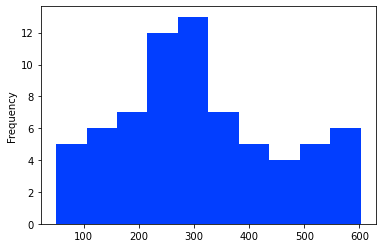

In [12]:
df_loc.zipcode.value_counts().plot(kind='hist')
# most zipcode/area has about 200-300 houses sales

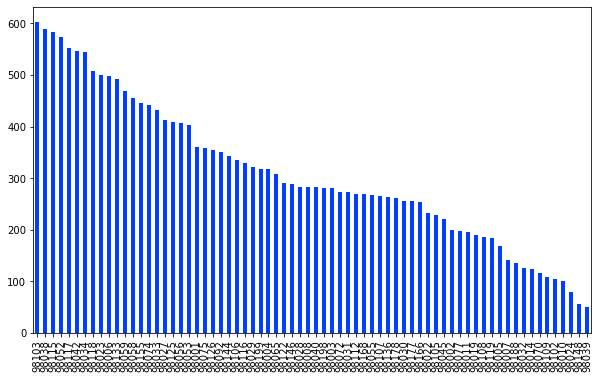

In [13]:
fig, ax = plt.subplots(figsize=(10,6))
df_loc.zipcode.value_counts().plot(kind='bar');

# zipcode/area with more houses
# DON'T USE IT!!!!

In [14]:
df_loc = pd.get_dummies(df_loc,columns=['zipcode'],drop_first=True)
df_loc.head(3)

,price,sqft_living,zipcode_98002,zipcode_98003,zipcode_98004,zipcode_98005,zipcode_98006,zipcode_98007,zipcode_98008,zipcode_98010,...,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
0,221900.0,1180,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,538000.0,2570,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,180000.0,770,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
# check in model with zipcode
y = df_loc['price']
X = df_loc.drop(columns=['price'])

model = sm.OLS(y, sm.add_constant(X))
results = model.fit()

print('R2 with zipcode: ', results.rsquared)

# pretty good R-squared

R2 with zipcode:  0.729951663939566


In [16]:
# add waterfront, view to test
df_loc = df_loc.join(df[['waterfront','view']],on=df_loc.index)

In [17]:
# check in model with zipcode
y = df_loc['price']
X = df_loc.drop(columns=['price'])

model = sm.OLS(y, sm.add_constant(X))
results = model.fit()

print('R2 with zipcode, waterfront, view: ', results.rsquared)

# pretty good R-squared

R2 with zipcode, waterfront, view:  0.7816789275165473


In [18]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.782
Model:                            OLS   Adj. R-squared:                  0.781
Method:                 Least Squares   F-statistic:                     1070.
Date:                Fri, 16 Sep 2022   Prob (F-statistic):               0.00
Time:                        10:10:04   Log-Likelihood:            -2.9096e+05
No. Observations:               21597   AIC:                         5.821e+05
Df Residuals:                   21524   BIC:                         5.826e+05
Df Model:                          72                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -1.573e+05   9468.640    -16.608

In [19]:
df_loc = df_loc.join(df[['zipcode']],on=df_loc.index)

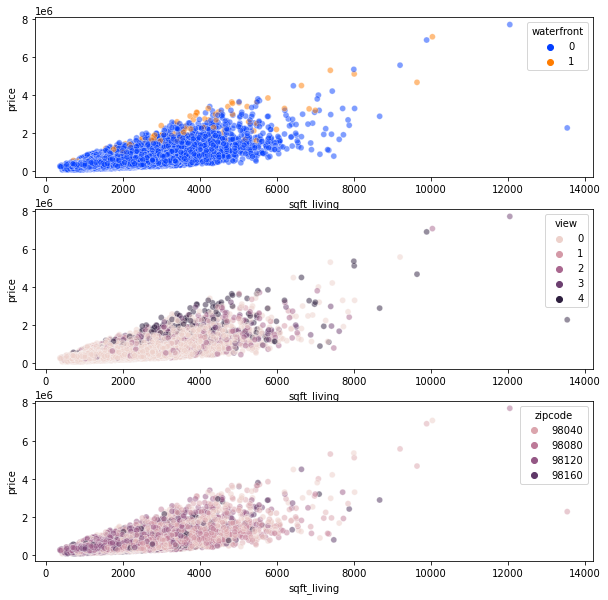

In [20]:
fig,axes = plt.subplots(nrows=3, ncols=1, figsize=(10,10))
sns.scatterplot(hue = 'waterfront', y = 'price', x = 'sqft_living', data = df_loc, palette='bright', alpha=0.5, ax=axes[0])
sns.scatterplot(hue = 'view', y = 'price', x = 'sqft_living', data = df_loc,alpha=0.5, ax=axes[1])
sns.scatterplot(hue = 'zipcode', y = 'price', x = 'sqft_living', data = df_loc,alpha=0.5, ax=axes[2]);

# group the zipcode to make a better plot
# group by pval? density in one location/zipcode?

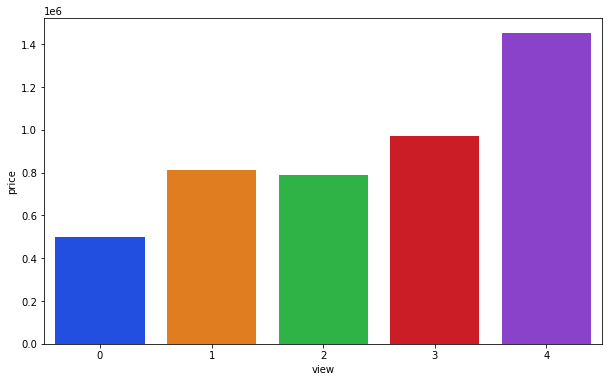

In [21]:
fig,ax = plt.subplots(figsize=(10,6))
sns.barplot(data = df_loc, x = 'view', y = 'price', ci=None, ax=ax);

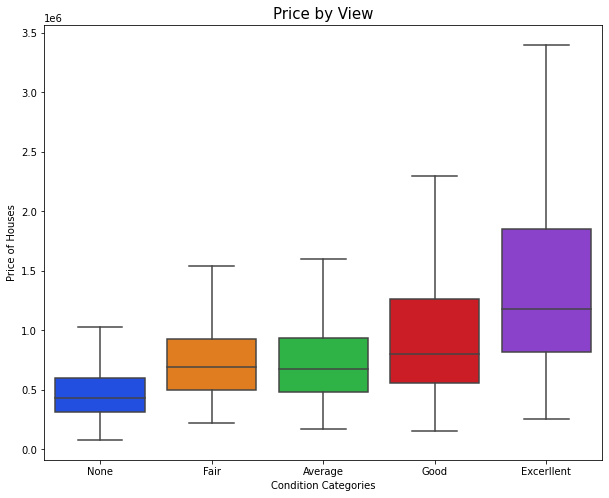

In [74]:
fig,ax = plt.subplots(figsize=(10,8))
g = sns.boxplot( x = 'view', y = 'price', showfliers = False, data = df_loc)
plt.title('Price by View',fontsize=15)
ax.set_xlabel('View Categories')
ax.set_ylabel('Price of Houses')
g.set_xticks(range(5))
g.set_xticklabels(['None','Fair','Average','Good','Excerllent']);

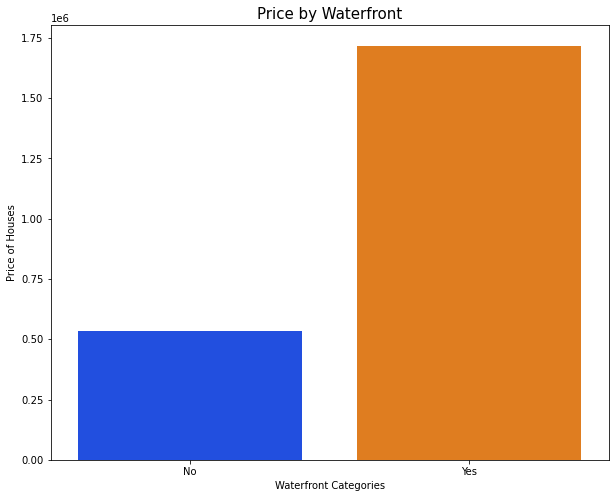

In [78]:
fig,ax = plt.subplots(figsize=(10,8))
g = sns.barplot(data = df_loc, x = 'waterfront', y = 'price', ci=None, ax=ax)
plt.title('Price by Waterfront',fontsize=15)
ax.set_xlabel('Waterfront Categories')
ax.set_ylabel('Price of Houses')
g.set_xticks(range(2))
g.set_xticklabels(['No','Yes']);

# EDA LIVING SPACE

In [23]:
col_selector = ['price','bedrooms','bathrooms','floors','sqft_living','sqft_lot','sqft_above','sqft_basement']
df_ls = df[col_selector]

In [24]:
df_ls.columns

Index(['price', 'bedrooms', 'bathrooms', 'floors', 'sqft_living', 'sqft_lot',
       'sqft_above', 'sqft_basement'],
      dtype='object')

In [25]:
# check in model with
# bedroom, bathroom, floor
y = df_ls['price']
X = df_ls[['bedrooms', 'bathrooms', 'floors']]

model = sm.OLS(y, sm.add_constant(X))
results = model.fit()

print(results.summary())

# keep bedroom, bathroom
# drop floor

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.279
Model:                            OLS   Adj. R-squared:                  0.279
Method:                 Least Squares   F-statistic:                     2780.
Date:                Fri, 16 Sep 2022   Prob (F-statistic):               0.00
Time:                        10:10:06   Log-Likelihood:            -3.0386e+05
No. Observations:               21597   AIC:                         6.077e+05
Df Residuals:                   21593   BIC:                         6.078e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3.316e+04   9356.298     -3.544      0.0

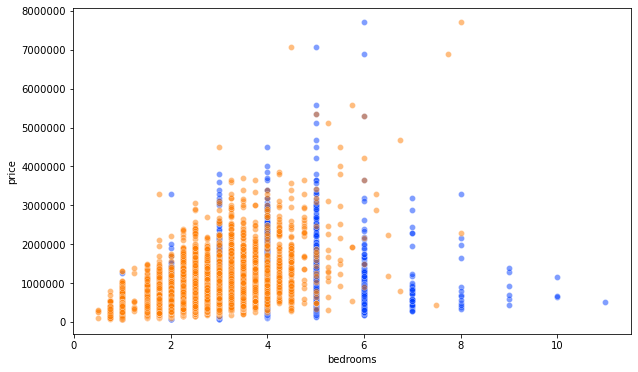

In [26]:
fig,ax = plt.subplots(figsize=(10,6))
sns.scatterplot(x = 'bedrooms', y = 'price', data = df_ls,alpha=0.5)
sns.scatterplot(x = 'bathrooms', y = 'price', data = df_ls,alpha=0.5)
ax.ticklabel_format(style='plain');

In [27]:
# bedroom and bathroom ratio
df_ls['BR/BTH'] = df_ls['bedrooms']/df_ls['bathrooms']
df_ls['BR/BTH'] = df_ls['BR/BTH'].map(lambda x: round(x,2))

<ipython-input-27-6050806a8546>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ls['BR/BTH'] = df_ls['bedrooms']/df_ls['bathrooms']
<ipython-input-27-6050806a8546>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ls['BR/BTH'] = df_ls['BR/BTH'].map(lambda x: round(x,2))


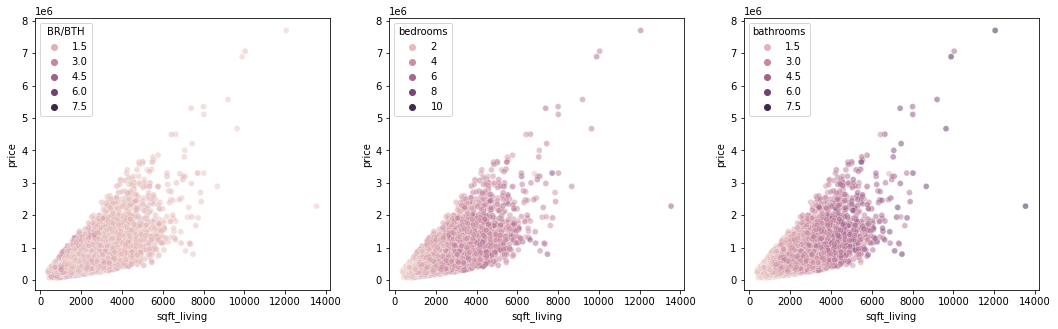

In [28]:
fig,axes = plt.subplots(nrows=1, ncols=3, figsize=(18,5))
sns.scatterplot(hue = 'BR/BTH', y = 'price', x = 'sqft_living', data = df_ls,alpha=0.5, ax=axes[0])
sns.scatterplot(hue = 'bedrooms', y = 'price', x = 'sqft_living', data = df_ls,alpha=0.5, ax=axes[1])
sns.scatterplot(hue = 'bathrooms', y = 'price', x = 'sqft_living', data = df_ls,alpha=0.5, ax=axes[2]);

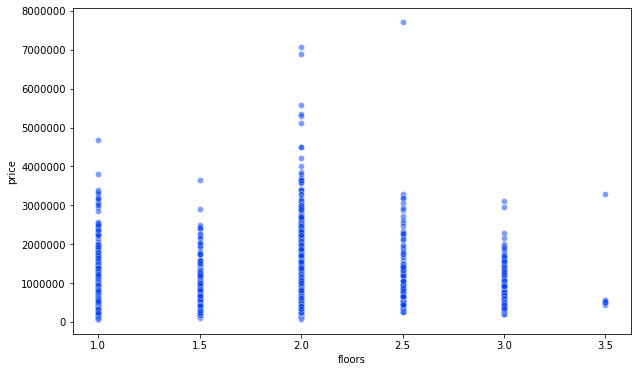

In [29]:
fig,ax = plt.subplots(figsize=(10,6))
sns.scatterplot(x = 'floors', y = 'price', data = df_ls,alpha=0.5)
ax.ticklabel_format(style='plain');
# some floors seems to have higher price

Create new columns by combining

In [30]:
# FAR: Floor Area Ratio
df_ls['FAR'] = df_ls['sqft_living'] / df_ls['sqft_lot']
df_ls['FAR'] = df_ls['FAR'].map(lambda x: round(x,2))

# according to a report for .. in NYC IN 2022
# higher FAR mean more land value

<ipython-input-30-0cf0bff2c0b4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ls['FAR'] = df_ls['sqft_living'] / df_ls['sqft_lot']
<ipython-input-30-0cf0bff2c0b4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ls['FAR'] = df_ls['FAR'].map(lambda x: round(x,2))


In [31]:
# attempt to calculate the yard
# suppose first floor area = (living-basement) / floors
# yard will be: lot - first floor

df_ls['yard'] = df_ls['sqft_lot'] - ((df_ls['sqft_living'] - df_ls['sqft_basement']) / df_ls['floors'])

<ipython-input-31-6c3a2c5936ef>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ls['yard'] = df_ls['sqft_lot'] - ((df_ls['sqft_living'] - df_ls['sqft_basement']) / df_ls['floors'])


In [32]:
df_ls.head(3)

,price,bedrooms,bathrooms,floors,sqft_living,sqft_lot,sqft_above,sqft_basement,BR/BTH,FAR,yard
0,221900.0,3,1.0,1.0,1180,5650,1180,0,3.0,0.21,4470.0
1,538000.0,3,2.25,2.0,2570,7242,2170,400,1.33,0.35,6157.0
2,180000.0,2,1.0,1.0,770,10000,770,0,2.0,0.08,9230.0


In [33]:
# Living space / bedrooms
# higher means you have more space for other rooms
# such as kitchen, living room, game room, home gym
df_ls['Living_Space_VS_Bedroom'] = (df_ls['sqft_living'] - df_ls['sqft_basement'])/df_ls['bedrooms']
df_ls['Living_Space_VS_Bedroom'] = df_ls['Living_Space_VS_Bedroom'].map(lambda x: round(x,2))

<ipython-input-33-5beb693b50c3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ls['Living_Space_VS_Bedroom'] = (df_ls['sqft_living'] - df_ls['sqft_basement'])/df_ls['bedrooms']
<ipython-input-33-5beb693b50c3>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ls['Living_Space_VS_Bedroom'] = df_ls['Living_Space_VS_Bedroom'].map(lambda x: round(x,2))


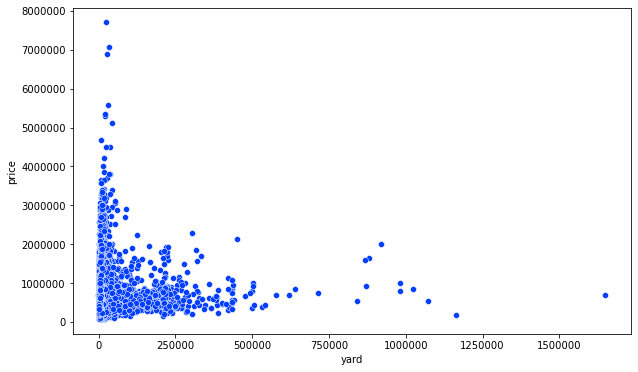

In [34]:
fig,ax = plt.subplots(figsize=(10,6))
sns.scatterplot(x = 'yard', y = 'price', data = df_ls)
ax.ticklabel_format(style='plain');

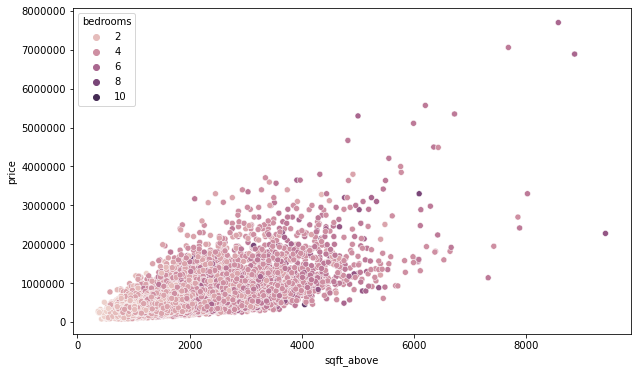

In [35]:
fig,ax = plt.subplots(figsize=(10,6))
sns.scatterplot(x = 'sqft_above', y = 'price', hue = 'bedrooms', data = df_ls)
ax.ticklabel_format(style='plain');

In [36]:
df_ls['lot_per_floor'] = df_ls['sqft_lot'] / df_ls['floors']
df_ls['lot_per_floor'] = df_ls['lot_per_floor'].map(lambda x: round(x,2))

<ipython-input-36-b62fb3adf33b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ls['lot_per_floor'] = df_ls['sqft_lot'] / df_ls['floors']
<ipython-input-36-b62fb3adf33b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ls['lot_per_floor'] = df_ls['lot_per_floor'].map(lambda x: round(x,2))


In [37]:
df_ls['living_per_floor'] = df_ls['sqft_above'] / df_ls['floors']
df_ls['living_per_floor'] = df_ls['living_per_floor'].map(lambda x: round(x,2))

<ipython-input-37-eb7c54e3fdd9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ls['living_per_floor'] = df_ls['sqft_above'] / df_ls['floors']
<ipython-input-37-eb7c54e3fdd9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ls['living_per_floor'] = df_ls['living_per_floor'].map(lambda x: round(x,2))


In [38]:
df_ls['living_per_lot'] = df_ls['sqft_above'] / df_ls['sqft_lot']
df_ls['living_per_lot'] = df_ls['living_per_lot'].map(lambda x: round(x,2))

<ipython-input-38-62735b98add0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ls['living_per_lot'] = df_ls['sqft_above'] / df_ls['sqft_lot']
<ipython-input-38-62735b98add0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ls['living_per_lot'] = df_ls['living_per_lot'].map(lambda x: round(x,2))


In [39]:
df_ls

,price,bedrooms,bathrooms,floors,sqft_living,sqft_lot,sqft_above,sqft_basement,BR/BTH,FAR,yard,Living_Space_VS_Bedroom,lot_per_floor,living_per_floor,living_per_lot
0,221900.0,3,1.0,1.0,1180,5650,1180,0,3.0,0.21,4470.0,393.33,5650.0,1180.0,0.21
1,538000.0,3,2.25,2.0,2570,7242,2170,400,1.33,0.35,6157.0,723.33,3621.0,1085.0,0.3
2,180000.0,2,1.0,1.0,770,10000,770,0,2.0,0.08,9230.0,385.0,10000.0,770.0,0.08
3,604000.0,4,3.0,1.0,1960,5000,1050,910,1.33,0.39,3950.0,262.5,5000.0,1050.0,0.21
4,510000.0,3,2.0,1.0,1680,8080,1680,0,1.5,0.21,6400.0,560.0,8080.0,1680.0,0.21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,360000.0,3,2.5,3.0,1530,1131,1530,0,1.2,1.35,621.0,510.0,377.0,510.0,1.35
21593,400000.0,4,2.5,2.0,2310,5813,2310,0,1.6,0.4,4658.0,577.5,2906.5,1155.0,0.4
21594,402101.0,2,0.75,2.0,1020,1350,1020,0,2.67,0.76,840.0,510.0,675.0,510.0,0.76
21595,400000.0,3,2.5,2.0,1600,2388,1600,0,1.2,0.67,1588.0,533.33,1194.0,800.0,0.67


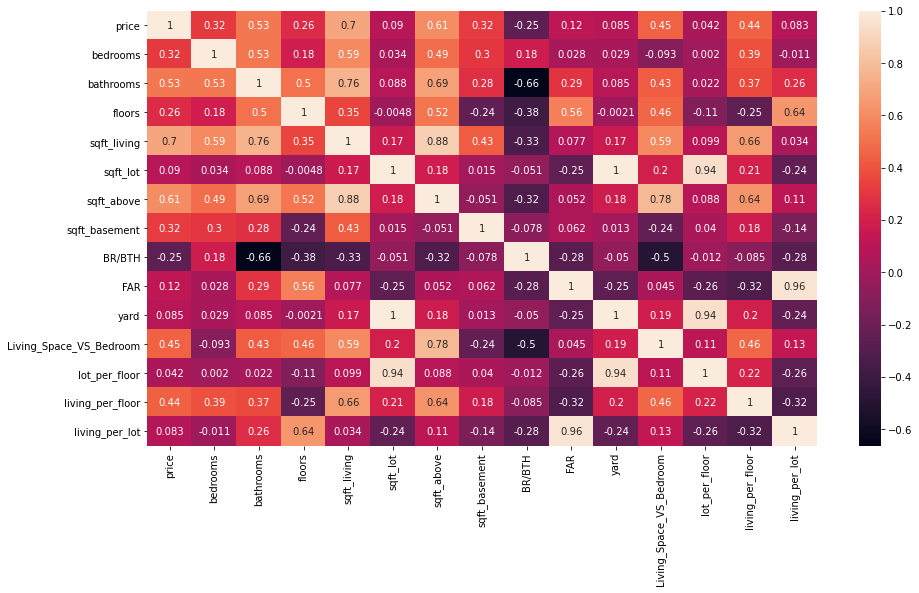

In [40]:
plt.figure(figsize=(15, 8))
sns.heatmap(df_ls.corr(),annot=True);

In [41]:
df_ls.columns

Index(['price', 'bedrooms', 'bathrooms', 'floors', 'sqft_living', 'sqft_lot',
       'sqft_above', 'sqft_basement', 'BR/BTH', 'FAR', 'yard',
       'Living_Space_VS_Bedroom', 'lot_per_floor', 'living_per_floor',
       'living_per_lot'],
      dtype='object')

In [42]:
# check in model with above features

y = df_ls['price']
X = df_loc.drop(columns=['price'])

model = sm.OLS(y, sm.add_constant(X))
results = model.fit()


print('R2 with zipcode: ', results.summary())

R2 with zipcode:                              OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.782
Model:                            OLS   Adj. R-squared:                  0.781
Method:                 Least Squares   F-statistic:                     1070.
Date:                Fri, 16 Sep 2022   Prob (F-statistic):               0.00
Time:                        10:10:11   Log-Likelihood:            -2.9096e+05
No. Observations:               21597   AIC:                         5.821e+05
Df Residuals:                   21524   BIC:                         5.826e+05
Df Model:                          72                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -1.215e+04    

In [43]:
# check in model with above features
col_selector = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'sqft_above', 'BR/BTH', 'FAR', 'yard', 'living_per_lot']

y = df_ls['price']
X = df_ls[col_selector]

scaler = StandardScaler().fit(X)
X_std = scaler.transform(X)

model = sm.OLS(y, sm.add_constant(X_std))
results = model.fit()


print('R2 with zipcode: ', results.summary())

R2 with zipcode:                              OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.526
Model:                            OLS   Adj. R-squared:                  0.526
Method:                 Least Squares   F-statistic:                     2661.
Date:                Fri, 16 Sep 2022   Prob (F-statistic):               0.00
Time:                        10:10:11   Log-Likelihood:            -2.9933e+05
No. Observations:               21597   AIC:                         5.987e+05
Df Residuals:                   21587   BIC:                         5.988e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.403e+05   1721.557  

In [44]:
# standardize it to see the result

y = df_ls['price']
X = df_ls.drop(columns=['price'])

scaler = StandardScaler().fit(X)
X_std = scaler.transform(X)


model = sm.OLS(y, sm.add_constant(X_std))
results = model.fit()


print('R2 with zipcode: ', results.summary())


R2 with zipcode:                              OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.528
Model:                            OLS   Adj. R-squared:                  0.528
Method:                 Least Squares   F-statistic:                     1725.
Date:                Fri, 16 Sep 2022   Prob (F-statistic):               0.00
Time:                        10:10:11   Log-Likelihood:            -2.9928e+05
No. Observations:               21597   AIC:                         5.986e+05
Df Residuals:                   21582   BIC:                         5.987e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.403e+05   1717.763  

## EDA HOUSE CONDITION

In [45]:
df.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [46]:
col_selector = ['price','grade','condition','yr_built', 'yr_renovated','sqft_living']
df_condition = df[col_selector]
df_condition.head()

,price,grade,condition,yr_built,yr_renovated,sqft_living
0,221900.0,7,2,1955,0.0,1180
1,538000.0,7,2,1951,1991.0,2570
2,180000.0,6,2,1933,0.0,770
3,604000.0,7,4,1965,0.0,1960
4,510000.0,8,2,1987,0.0,1680


<AxesSubplot:xlabel='condition', ylabel='price'>

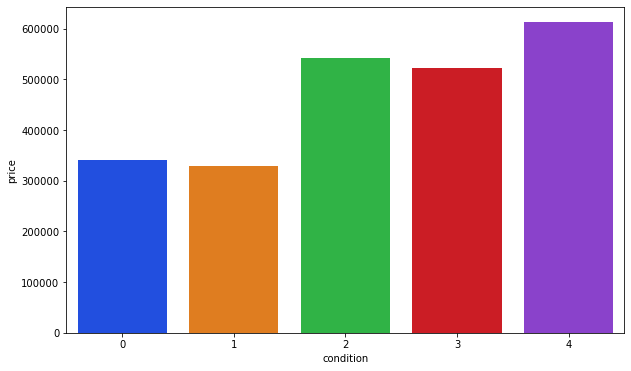

In [47]:
fig,ax = plt.subplots(figsize=(10,6))
sns.barplot(x = 'condition', y = 'price', ci = None, data = df_condition)

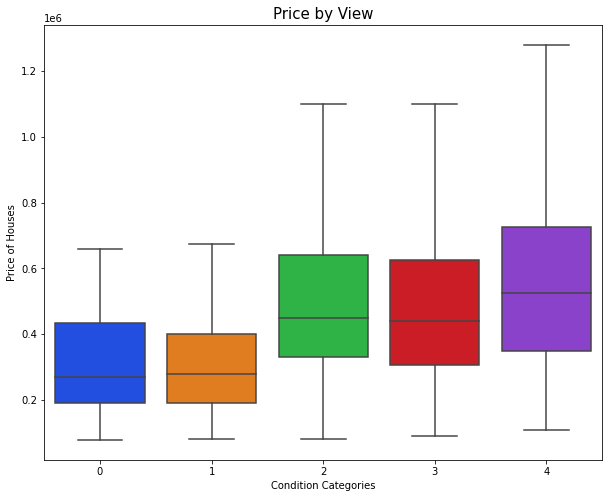

In [69]:
fig,ax = plt.subplots(figsize=(10,8))
sns.boxplot(x = 'condition', y = 'price', showfliers = False, data = df_condition)
plt.title('Price by View',fontsize=15)
ax.set_xlabel('Condition Categories')
ax.set_ylabel('Price of Houses');

<AxesSubplot:xlabel='grade', ylabel='price'>

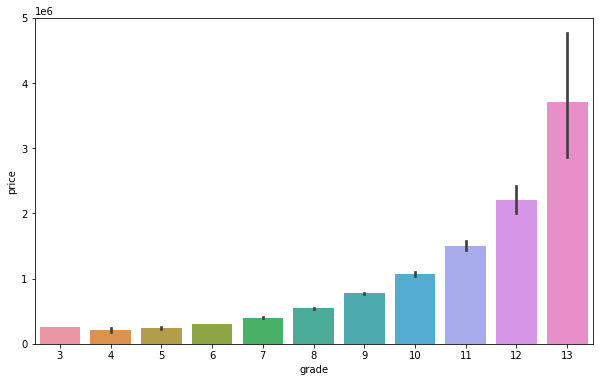

In [59]:
fig,ax = plt.subplots(figsize=(10,6))
sns.barplot(x = 'grade', y = 'price', data = df_condition,ax=ax)

In [60]:
df_condition.yr_built.value_counts().sort_index()

1900     87
1901     29
1902     27
1903     46
1904     45
       ... 
2011    130
2012    170
2013    201
2014    559
2015     38
Name: yr_built, Length: 116, dtype: int64

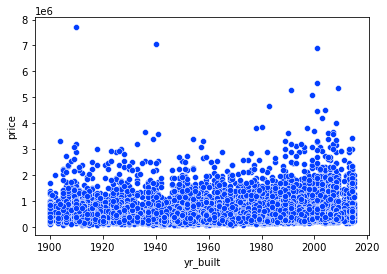

In [61]:
sns.scatterplot(x = 'yr_built', y = 'price', data = df_condition);
# can't tell much

In [62]:
bins = np.arange(1900,2030,10)
labels = np.arange(1,13,1)
df_condition['yr_built_pd'] = pd.cut(df_condition.yr_built, bins = bins, labels = labels,
       include_lowest=True)

<ipython-input-62-570a6d7b7d46>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_condition['yr_built_pd'] = pd.cut(df_condition.yr_built, bins = bins, labels = labels,


In [63]:
list(zip(np.arange(1900,2020,10),np.arange(1910,2030,10)))

[(1900, 1910),
 (1910, 1920),
 (1920, 1930),
 (1930, 1940),
 (1940, 1950),
 (1950, 1960),
 (1960, 1970),
 (1970, 1980),
 (1980, 1990),
 (1990, 2000),
 (2000, 2010),
 (2010, 2020)]

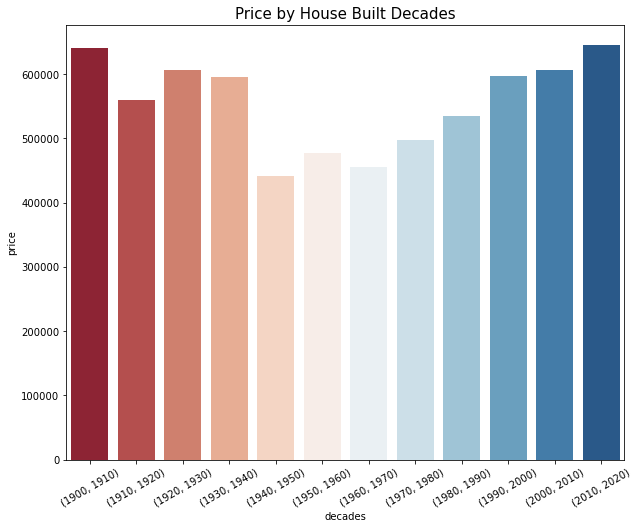

In [83]:
fig, ax = plt.subplots(figsize=(10,8))
g = sns.barplot(x = 'yr_built_pd', y = 'price', ci=None, palette='RdBu', data = df_condition,ax=ax)
g.set_xticks(range(12))
g.set_xticklabels(list(zip(np.arange(1900,2020,10),np.arange(1910,2030,10))),rotation = 30)
plt.title('Price by House Built Decades',fontsize=15)
ax.set_xlabel('decades')
ax.set_ylabel('price');

# older house are more expensive
# maybe old house + renovated more expensive?

In [85]:
df_condition['renovated']= df_condition['yr_renovated'].apply(lambda x: 0 if x == 0.0 else 1)
# 1 means renovated, 0 means no
# assume renovated year doesn't matter

<ipython-input-85-8d08a4d84c18>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_condition['renovated']= df_condition['yr_renovated'].apply(lambda x: 0 if x == 0.0 else 1)


In [86]:
df_condition.renovated

0        0
1        1
2        0
3        0
4        0
        ..
21592    0
21593    0
21594    0
21595    0
21596    0
Name: renovated, Length: 21597, dtype: int64

how about range the yr renovated?

In [88]:
df.yr_renovated.value_counts().sort_index()

0.0       20853
1934.0        1
1940.0        2
1944.0        1
1945.0        3
          ...  
2011.0        9
2012.0        8
2013.0       31
2014.0       73
2015.0       14
Name: yr_renovated, Length: 70, dtype: int64

In [89]:
bins = [0, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010, 2020]
labels = np.arange(1,11,1)
df_condition['yr_renovated_pd'] = pd.cut(df_condition.yr_renovated, bins = bins, labels = labels,
       include_lowest=True)

<ipython-input-89-8abea5cc995b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_condition['yr_renovated_pd'] = pd.cut(df_condition.yr_renovated, bins = bins, labels = labels,


In [90]:
list(zip(np.arange(1930,2010,10),np.arange(1940,2020,10)))

[(1930, 1940),
 (1940, 1950),
 (1950, 1960),
 (1960, 1970),
 (1970, 1980),
 (1980, 1990),
 (1990, 2000),
 (2000, 2010)]

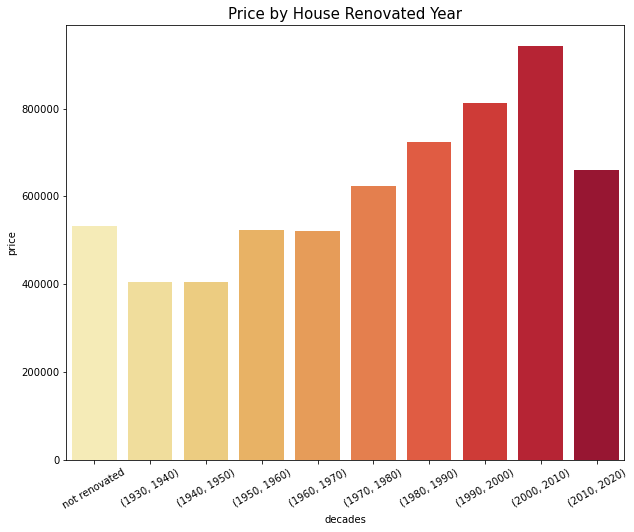

In [92]:
fig, ax = plt.subplots(figsize=(10,8))
g = sns.barplot(x = 'yr_renovated_pd', y = 'price', ci = None, palette = 'YlOrRd',data = df_condition);
g.set_xticks(range(10))
g.set_xticklabels(['not renovated',(1930, 1940), (1940, 1950), (1950, 1960), (1960, 1970), 
                   (1970, 1980), (1980, 1990), (1990, 2000), (2000, 2010),(2010,2020)], rotation = 30)
plt.title('Price by House Renovated Year',fontsize=15)
ax.set_xlabel('decades')
ax.set_ylabel('price');

# renovated lately really matters

how about yr_built + renovated?

In [93]:
bins = [0, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010, 2020]
labels = np.arange(10,0,-1)
df_condition['renovated_recently_pd'] = pd.cut(df_condition.yr_renovated, bins = bins, labels = labels,
       include_lowest=True)

<ipython-input-93-a3930a818d23>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_condition['renovated_recently_pd'] = pd.cut(df_condition.yr_renovated, bins = bins, labels = labels,


In [94]:
df_condition.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   price                  21597 non-null  float64 
 1   grade                  21597 non-null  int64   
 2   condition              21597 non-null  int64   
 3   yr_built               21597 non-null  int64   
 4   yr_renovated           21597 non-null  float64 
 5   sqft_living            21597 non-null  int64   
 6   yr_built_pd            21597 non-null  category
 7   renovated              21597 non-null  int64   
 8   yr_renovated_pd        21597 non-null  category
 9   renovated_recently_pd  21597 non-null  category
dtypes: category(3), float64(2), int64(5)
memory usage: 1.2 MB


In [95]:
df_condition['yr_built_pd'] = df_condition['yr_built_pd'].astype(int)
df_condition['yr_renovated_pd'] = df_condition['yr_renovated_pd'].astype(int)
df_condition['renovated_recently_pd'] = df_condition['renovated_recently_pd'].astype(int)

<ipython-input-95-e3726f857272>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_condition['yr_built_pd'] = df_condition['yr_built_pd'].astype(int)
<ipython-input-95-e3726f857272>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_condition['yr_renovated_pd'] = df_condition['yr_renovated_pd'].astype(int)
<ipython-input-95-e3726f857272>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

In [96]:
df_condition['built_and_renovated'] = df_condition['yr_built_pd'] * df_condition['renovated_recently_pd']

<ipython-input-96-530e2a0d016b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_condition['built_and_renovated'] = df_condition['yr_built_pd'] * df_condition['renovated_recently_pd']


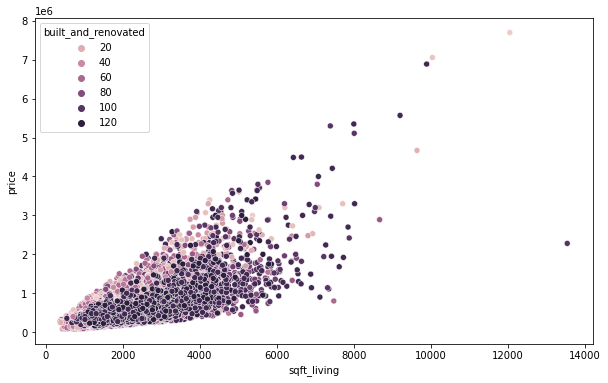

In [97]:
fig,ax = plt.subplots(figsize=(10,6))
sns.scatterplot(x = 'sqft_living', y = 'price', hue = 'built_and_renovated', data = df_condition,ax=ax);

In [98]:
# create a feature for old house + renovated lately

In [99]:
df_condition

,price,grade,condition,yr_built,yr_renovated,sqft_living,yr_built_pd,renovated,yr_renovated_pd,renovated_recently_pd,built_and_renovated
0,221900.0,7,2,1955,0.0,1180,6,0,1,10,60
1,538000.0,7,2,1951,1991.0,2570,6,1,8,3,18
2,180000.0,6,2,1933,0.0,770,4,0,1,10,40
3,604000.0,7,4,1965,0.0,1960,7,0,1,10,70
4,510000.0,8,2,1987,0.0,1680,9,0,1,10,90
...,...,...,...,...,...,...,...,...,...,...,...
21592,360000.0,8,2,2009,0.0,1530,11,0,1,10,110
21593,400000.0,8,2,2014,0.0,2310,12,0,1,10,120
21594,402101.0,7,2,2009,0.0,1020,11,0,1,10,110
21595,400000.0,8,2,2004,0.0,1600,11,0,1,10,110


In [103]:
df_condition['old_house_renovated_lately']  = np.where(((df_condition['yr_built_pd'] <= 4) & (df_condition.yr_renovated_pd >= 6)), 1,0)

<ipython-input-103-5c56e56df971>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_condition['old_house_renovated_lately']  = np.where(((df_condition['yr_built_pd'] <= 4) & (df_condition.yr_renovated_pd >= 6)), 1,0)


In [104]:
df_condition.old_house_renovated_lately.sum()

302

In [105]:
bins = np.arange(1900,2030,10)
labels = np.arange(1,13,1)
bins, labels

(array([1900, 1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000,
        2010, 2020]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]))

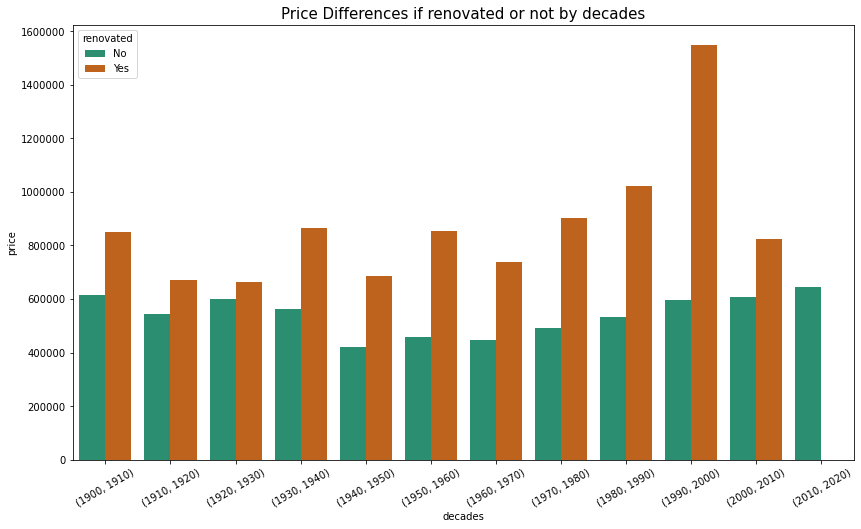

In [108]:
fig,ax = plt.subplots(figsize=(14,8))
g = sns.barplot(x = 'yr_built_pd', y = 'price', hue = 'renovated', data = df_condition, 
                palette='Dark2', ci = None, ax = ax)
ax.set_title('price different if renovated or not by decades')
ax.set_xlabel('decade')
ax.set_ylabel('price')
g.set_xticks(range(12))
g.set_xticklabels(list(zip(np.arange(1900,2020,10),np.arange(1910,2030,10))), rotation = 30)
plt.legend(title='renovated', labels=['No', 'Yes'])
plt.ticklabel_format(style='plain', axis='y')
plt.title('Price Differences if renovated or not by decades',fontsize=15)
ax.set_xlabel('decades')
ax.set_ylabel('price');

In [259]:
df_condition[(df_condition.yr_built>=2010) & (df_condition.renovated == 1)] 

,price,grade,condition,yr_built,yr_renovated,sqft_living,yr_built_pd,renovated,yr_renovated_pd,renovated_recently_pd,built_and_renovated,old_house_renovated_lately


In [118]:
# check in model with zipcode
y = df_condition['price']
X = df_condition.drop(columns=['price'])

model = sm.OLS(y, sm.add_constant(X))
results = model.fit()

print('R2 with zipcode: ', results.summary())

R2 with zipcode:                              OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.606
Method:                 Least Squares   F-statistic:                     3327.
Date:                Thu, 15 Sep 2022   Prob (F-statistic):               0.00
Time:                        11:06:41   Log-Likelihood:            -2.9732e+05
No. Observations:               21597   AIC:                         5.947e+05
Df Residuals:                   21586   BIC:                         5.948e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
co

In [124]:
# check in model
y = df_condition['price']
X = df_condition.drop(columns=['price'])

scaler = StandardScaler().fit(X)
X_std = scaler.transform(X)

model = sm.OLS(y, sm.add_constant(X_std))
results = model.fit()

print('R2 with zipcode: ', results.summary())

R2 with zipcode:                              OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.606
Method:                 Least Squares   F-statistic:                     3327.
Date:                Thu, 15 Sep 2022   Prob (F-statistic):               0.00
Time:                        11:08:44   Log-Likelihood:            -2.9732e+05
No. Observations:               21597   AIC:                         5.947e+05
Df Residuals:                   21586   BIC:                         5.948e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.403e+05   1568.551  

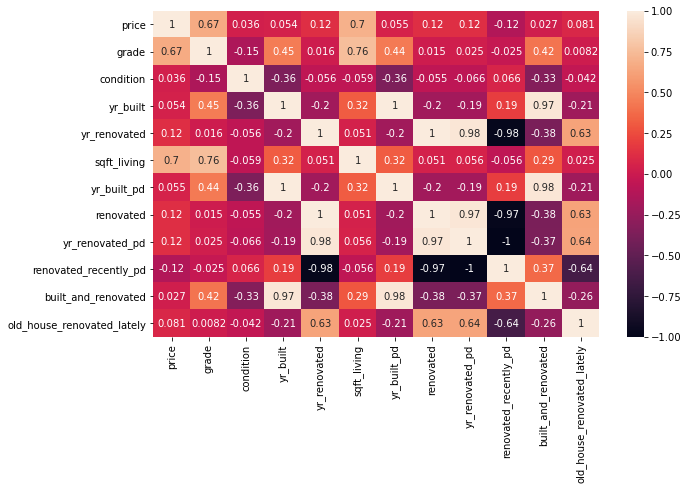

In [110]:
fig,ax = plt.subplots(figsize=(10,6))
sns.heatmap(df_condition.corr(),annot=True,ax=ax);

In [ ]:
# sns.pairplot(df_condition)

# OUTPUT! CSV AND CALL IT A DAY!

## select features

### baseline feature

In [137]:
df.columns,df.shape

(Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
        'waterfront', 'view', 'condition', 'grade', 'sqft_above',
        'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
        'sqft_living15', 'sqft_lot15'],
       dtype='object'),
 (21597, 19))

In [138]:
col_selector = ['price','sqft_living','bedrooms','bathrooms','condition']
df_sel = df[col_selector]

### location

In [139]:
df_loc.columns, df_loc.shape

(Index(['price', 'sqft_living', 'zipcode_98002', 'zipcode_98003',
        'zipcode_98004', 'zipcode_98005', 'zipcode_98006', 'zipcode_98007',
        'zipcode_98008', 'zipcode_98010', 'zipcode_98011', 'zipcode_98014',
        'zipcode_98019', 'zipcode_98022', 'zipcode_98023', 'zipcode_98024',
        'zipcode_98027', 'zipcode_98028', 'zipcode_98029', 'zipcode_98030',
        'zipcode_98031', 'zipcode_98032', 'zipcode_98033', 'zipcode_98034',
        'zipcode_98038', 'zipcode_98039', 'zipcode_98040', 'zipcode_98042',
        'zipcode_98045', 'zipcode_98052', 'zipcode_98053', 'zipcode_98055',
        'zipcode_98056', 'zipcode_98058', 'zipcode_98059', 'zipcode_98065',
        'zipcode_98070', 'zipcode_98072', 'zipcode_98074', 'zipcode_98075',
        'zipcode_98077', 'zipcode_98092', 'zipcode_98102', 'zipcode_98103',
        'zipcode_98105', 'zipcode_98106', 'zipcode_98107', 'zipcode_98108',
        'zipcode_98109', 'zipcode_98112', 'zipcode_98115', 'zipcode_98116',
        'zipcode_98117

In [140]:
col_selector = ['zipcode','view','waterfront']
df_loc_sel = df_loc[col_selector]

### living space

In [141]:
df_ls.columns, df_ls.shape

(Index(['price', 'bedrooms', 'bathrooms', 'floors', 'sqft_living', 'sqft_lot',
        'sqft_above', 'sqft_basement', 'BR/BTH', 'FAR', 'yard', 'lot_per_floor',
        'living_per_floor', 'living_per_lot'],
       dtype='object'),
 (21597, 14))

In [142]:
# select all
col_selector = ['floors', 'sqft_lot',
        'sqft_above', 'sqft_basement', 'BR/BTH', 'FAR', 'yard', 'lot_per_floor',
        'living_per_floor', 'living_per_lot']
df_ls_sel = df_ls[col_selector]

### investment-wise house condition

In [143]:
df_condition.columns

Index(['price', 'grade', 'condition', 'yr_built', 'yr_renovated',
       'sqft_living', 'yr_built_pd', 'renovated', 'yr_renovated_pd',
       'renovated_recently_pd', 'built_and_renovated',
       'old_house_renovated_lately'],
      dtype='object')

In [149]:
col_selector = ['grade','yr_built', 'yr_renovated',
       'yr_built_pd', 'renovated', 'built_and_renovated']
df_condition_sel = df_condition[col_selector]

## combine

In [150]:
df_output = pd.merge(df_sel,df_ls_sel, left_index=True, right_index=True)

In [151]:
df_output = pd.merge(df_output, df_condition_sel, left_index=True, right_index=True)

In [152]:
df_output = pd.merge(df_output, df_loc_sel, left_index=True, right_index=True)

In [153]:
df_output.columns

Index(['price', 'sqft_living', 'bedrooms', 'bathrooms', 'condition', 'floors',
       'sqft_lot', 'sqft_above', 'sqft_basement', 'BR/BTH', 'FAR', 'yard',
       'lot_per_floor', 'living_per_floor', 'living_per_lot', 'grade',
       'yr_built', 'yr_renovated', 'yr_built_pd', 'renovated',
       'built_and_renovated', 'zipcode', 'view', 'waterfront'],
      dtype='object')

In [155]:
df_output.shape

(21597, 24)

In [178]:
df_output.columns

Index(['price', 'sqft_living', 'bedrooms', 'bathrooms', 'condition', 'floors',
       'sqft_lot', 'sqft_above', 'sqft_basement', 'BR/BTH', 'FAR', 'yard',
       'lot_per_floor', 'living_per_floor', 'living_per_lot', 'grade',
       'yr_built', 'yr_renovated', 'yr_built_pd', 'renovated',
       'built_and_renovated', 'zipcode', 'view', 'waterfront'],
      dtype='object')

In [154]:
# df_output.to_csv(r'C:\Users\qwswe\Documents\Flatiron\DS_P2_King-County-House-Sales-Predict\Data_Han\df_for_model_2.csv', index = False)

# OUTPUT FOR TABLEAU

In [110]:
df_zipcode_counts = df.zipcode.value_counts()
df_zipcode_counts

98103    602
98038    589
98115    583
98052    574
98117    553
        ... 
98102    104
98010    100
98024     80
98148     57
98039     50
Name: zipcode, Length: 70, dtype: int64

In [120]:
df_zipcode_counts = df_zipcode_counts.reset_index()

In [122]:
df_zipcode_counts.columns = ['zipcode','zipcode_counts']

In [124]:
df_zipcode_counts

,zipcode,zipcode_counts
0,98103,602
1,98038,589
2,98115,583
3,98052,574
4,98117,553
...,...,...
65,98102,104
66,98010,100
67,98024,80
68,98148,57


In [125]:
df

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,221900.0,3,1.0,1180,5650,1.0,0,0,2,7,1180,0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,538000.0,3,2.25,2570,7242,2.0,0,0,2,7,2170,400,1951,1991.0,98125,47.721000000000004,-122.319,1690,7639
2,180000.0,2,1.0,770,10000,1.0,0,0,2,6,770,0,1933,0.0,98028,47.7379,-122.23299999999999,2720,8062
3,604000.0,4,3.0,1960,5000,1.0,0,0,4,7,1050,910,1965,0.0,98136,47.5208,-122.39299999999999,1360,5000
4,510000.0,3,2.0,1680,8080,1.0,0,0,2,8,1680,0,1987,0.0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,360000.0,3,2.5,1530,1131,3.0,0,0,2,8,1530,0,2009,0.0,98103,47.6993,-122.346,1530,1509
21593,400000.0,4,2.5,2310,5813,2.0,0,0,2,8,2310,0,2014,0.0,98146,47.5107,-122.36200000000001,1830,7200
21594,402101.0,2,0.75,1020,1350,2.0,0,0,2,7,1020,0,2009,0.0,98144,47.5944,-122.29899999999999,1020,2007
21595,400000.0,3,2.5,1600,2388,2.0,0,0,2,8,1600,0,2004,0.0,98027,47.5345,-122.069,1410,1287


In [138]:
df_tableau = pd.merge(df,df_zipcode_counts,on='zipcode')

In [139]:
df_tableau = df_tableau[['price','sqft_living','zipcode','zipcode_counts','lat','long']]

In [140]:
df_tableau.to_csv(r'C:\Users\qwswe\Documents\Flatiron\DS_P2_King-County-House-Sales-Predict\Data_Han\df_tableau.csv', index = False)

MY REFERENCE CODE

col_selector = ['price','zipcode','sqft_living']
df_loc = df[col_selector]
df_loc.head()



df_loc = pd.get_dummies(df_loc,columns=['zipcode'],drop_first=True)
df_loc.head(3)




# check in model with zipcode
y = df_loc['price']
X = df_loc.drop(columns=['price'])

model = sm.OLS(y, sm.add_constant(X))
results = model.fit()

print('R2 with zipcode: ', results.rsquared)



df_loc = df_loc.join(df[['waterfront','view']],on=df_loc.index)


fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(14,5))
sns.scatterplot(hue = 'floors', y = 'price', x = 'sqft_living', data = df_ls,alpha=0.5, ax=axes[0])
sns.scatterplot(x = 'floors', y = 'price', data = df_ls,alpha=0.5, ax=axes[1])
ax.ticklabel_format(style='plain');